# Before you begin (if you want to re-run the training parts):
* Modifidy appropriately the functions in models.py for the DeepCellState modification you want to use. For modified versions 1 and 2 follow the instructions in the methods of the NPJ publication.
* Use appropriate paths for your folders
* Use appropriate naming of your choice

In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Encoder,Decoder,VAE,CellStateEncoder,CellStateDecoder, CellStateVAE
# import argparse
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

#from scipy.stats import pearsonr
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

In [2]:
device = torch.device('cuda')

In [6]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HT29_A375.csv',index_col = 0)
#cmap_tf = pd.read_csv('../../../L1000_2021_11_23/cmap_compounds_tfs_repq1_tas03.tsv',
#                       sep='\t', low_memory=False, index_col=0)

gene_size = len(cmap.columns)
samples = cmap.index.values
# gene_size = len(cmap_tf.columns)
# samples = cmap_tf.index.values

# sampleInfo = pd.read_csv('../preprocessing/preprocessed_data/conditions_HT29_A375.csv',index_col = 0)

In [8]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# Cross validation

In [9]:
# from math import floor
# #sampleA375 = sampleInfo[sampleInfo['cell_iname']=='A375']
# #sampleHT29 = sampleInfo[sampleInfo['cell_iname']=='HT29']
# index_a375 = sampleInfo_a375.index
# index_ht29 = sampleInfo_ht29.index
# index_paired = sampleInfo_paired.index
# n_vals_a375 = floor(len(index_a375)*0.1)
# n_vals_ht29 = floor(len(index_ht29)*0.1)
# n_vals_paired = floor(len(index_paired)*0.1)

In [10]:
# # Split
# for i in range(10):
#     # Network
#     valInfo_a375 = sampleInfo_a375.loc[index_a375[-n_vals_a375:],:]
#     valInfo_ht29 = sampleInfo_ht29.loc[index_ht29[-n_vals_ht29:],:]
#     valInfo_paired = sampleInfo_paired.loc[index_paired[-n_vals_paired:],:]
#     trainInfo_a375 = sampleInfo_a375.drop(valInfo_a375.index)
#     trainInfo_ht29 = sampleInfo_ht29.drop(valInfo_ht29.index)
#     trainInfo_paired = sampleInfo_paired.drop(valInfo_paired.index)
#     #trainInfo = pd.concat([trainInfo_a375,trainInfo_ht29],axis=0)
#     #valInfo = pd.concat([valInfo_a375,valInfo_ht29],axis=0)
#     index_a375 = index_a375.drop(valInfo_a375.index)
#     index_ht29 = index_ht29.drop(valInfo_ht29.index)
#     index_paired = index_paired.drop(valInfo_paired.index)
    
#     trainInfo_a375.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i)
#     valInfo_a375.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i)
    
#     trainInfo_ht29.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i)
#     valInfo_ht29.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i)
    
#     trainInfo_paired.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i)
#     valInfo_paired.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i)

### Pretrain encoder,decoder

In [11]:
# Drop later validation sets
valInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_0.csv',index_col=0)
valInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_0.csv',index_col=0)
valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_0.csv',index_col=0)

for i in range(1,10):
    valInfo_a375 = pd.concat([valInfo_a375,
                              pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)])
    valInfo_ht29 = pd.concat([valInfo_ht29,
                              pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)])
    valInfo_paired = pd.concat([valInfo_paired,
                              pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)])
    
valInfo_paired = valInfo_paired.drop_duplicates()
valInfo_ht29 = valInfo_ht29.drop_duplicates()
valInfo_a375 = valInfo_a375.drop_duplicates()

In [16]:
cmap_all = pd.read_csv('../preprocessing/preprocessed_data/all_cmap_landmarks.csv',index_col = 0)
cmap_all = cmap_all.drop(valInfo_a375.sig_id)
cmap_all = cmap_all.drop(valInfo_ht29.sig_id)
cmap_all = cmap_all.drop(valInfo_paired['sig_id.x'])
cmap_all = cmap_all.drop(valInfo_paired['sig_id.y'])

cmap_train = cmap_all.sample(frac=0.8)
cmap_val = cmap_all.drop(cmap_train.index)
N = len(cmap_train)
#best_val_pear = -100.
#best_ep = 0

In [ ]:
NUM_EPOCHS = 1000
bs = 256
master_decoder = CellStateDecoder(128,gene_size,[256,512]).to(device)
master_encoder = CellStateEncoder(128,gene_size,[512,256]).to(device)
master_autoencoder = CellStateVAE(master_encoder,master_decoder).to(device)
optimizer = torch.optim.Adam(master_autoencoder.parameters(), lr= 0.0001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)
init_epochs = 10

In [ ]:
for e in range(0, NUM_EPOCHS):
    master_autoencoder.train()
    trainloader = getSamples(N, bs)
    for dataIndex in trainloader:
        optimizer.zero_grad()
        X = torch.tensor(cmap_train.iloc[dataIndex,:].values).float().to(device)
        z_latent , y_pred = master_autoencoder(X)
        true_samples = torch.autograd.Variable(torch.randn(z_latent.shape[0], z_latent.shape[1]), requires_grad=False)
        true_samples = true_samples.to(device)
        fitLoss = torch.mean(torch.sum((y_pred - X)**2,dim=1))+ compute_mmd(true_samples,z_latent)
        L1Loss = 1e-7 * torch.mean(torch.sum(torch.abs(z_latent),dim=1)) 
        loss = fitLoss + L1Loss
        
        loss.backward()

        optimizer.step()
        
        pearson = pearson_r(y_pred.detach().flatten(), X.detach().flatten())
        r2 = r_square(y_pred.detach().flatten(), X.detach().flatten())
        mse = torch.mean(torch.mean((y_pred.detach() - X.detach())**2,dim=1))
        
        outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
        outString += ', r2={:.4f}'.format(r2.item())
        outString += ', pearson={:.4f}'.format(pearson.item())
        outString += ', MSE={:.4f}'.format(mse.item())
        outString += ', loss={:.4f}'.format(loss.item())
        print(outString)
        clear_output(wait=True)
    scheduler.step()

In [ ]:
#master_autoencoder = torch.load('../results/deepcellstate_results/master_autoencoder.pt')

In [ ]:
master_autoencoder.eval()
X_val = torch.tensor(cmap_val.values).float().to(device)
zval , yval = master_autoencoder(X_val)
valpear = pearson_r(yval.detach(), X_val.detach()).detach()

In [ ]:
print(valpear.item())

In [ ]:
master_autoencoder.eval()
X = torch.tensor(cmap_train.values).float().to(device)
z , y = master_autoencoder(X)
pear = pearson_r(y.detach(), X.detach()).detach()
print(pear.item())

In [ ]:
# print(best_ep)
# print(best_val_pear)

In [ ]:
# torch.save(master_autoencoder,'../results/deepcellstate_results/master_autoencoder_no_noise_vae.pt')
#torch.save(master_encoder,'../results/deepcellstate_results/master_encoder.pt')
#torch.save(master_decoder,'../results/deepcellstate_results/master_decoder.pt')

### Load pre-trained auto-encoder

In [ ]:
# master_autoencoder = torch.load('../results/deepcellstate_results/master_autoencoder_no_noise.pt')

In [ ]:
decoder_a375 = CellStateDecoder(128,gene_size,[256,512])
decoder_ht29 = CellStateDecoder(128,gene_size,[256,512])
master_encoder = CellStateEncoder(128,gene_size,[512,256]).to(device)
#autoencoder_a375 = CellStateVAE(master_encoder,decoder_a375).to(device)
#autoencoder_ht29 = CellStateVAE(master_encoder,decoder_ht29).to(device)

In [ ]:
NUM_EPOCHS = 300
#bs = 128
bs_a375 = 45
bs_ht29 = 39
bs_paired = 22

In [ ]:
# NUM_EPOCHS = 1000
# #bs = 512
# bs_a375 = 178
# bs_ht29 = 154
# bs_paired = 90

In [ ]:
valR2 = []
valPear = []
valMSE =[]
valSpear = []
valAccuracy = []


valPearDirect = []
valSpearDirect = []
valAccDirect = []

valR2_a375 = []
valPear_a375 = []
valMSE_a375 =[]
valSpear_a375 = []
valAccuracy_a375 = []

valR2_ht29 = []
valPear_ht29 = []
valMSE_ht29 =[]
valSpear_ht29 = []
valAccuracy_ht29 = []

crossCorrelation = []

for i in range(10):
    # Network
    decoder_a375 = CellStateDecoder(128,gene_size,[256,512]).to(device)
    decoder_ht29 = CellStateDecoder(128,gene_size,[256,512]).to(device)
    master_encoder = CellStateEncoder(128,gene_size,[512,256]).to(device)
    master_encoder.load_state_dict(master_autoencoder.encoder.state_dict())
    decoder_a375.load_state_dict(master_autoencoder.decoder.state_dict())
    decoder_ht29.load_state_dict(master_autoencoder.decoder.state_dict())
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    N_paired = len(trainInfo_paired)
    N_a375 = len(trainInfo_a375)
    N_ht29 = len(trainInfo_ht29)
    N = N_a375
    if N_ht29>N:
        N=N_ht29
    
    allParams = list(master_encoder.parameters()) +list(decoder_a375.parameters()) + list(decoder_ht29.parameters())
    optimizer = torch.optim.Adam(allParams, lr= 0.0001, weight_decay=0)
    #optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)
        
    for e in range(0, NUM_EPOCHS):
        #autoencoder_a375.train()
        #autoencoder_ht29.train()
        decoder_a375.train()
        decoder_ht29.train()
        master_encoder.train()
        
        trainloader_a375 = getSamples(N_a375, bs_a375)
        len_a375 = len(trainloader_a375)
        trainloader_ht29 = getSamples(N_ht29, bs_ht29)
        len_ht29 = len(trainloader_ht29)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)

        lens = [len_a375,len_ht29,len_paired]
        maxLen = np.max(lens)

        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_a375, bs_a375)
            for jj in range(maxLen-lens[0]):
                trainloader_a375.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_ht29, bs_ht29)
            for jj in range(maxLen-lens[1]):
                trainloader_ht29.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_a375 = trainloader_a375[j]
            dataIndex_ht29 = trainloader_ht29[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_a375 = trainInfo_a375.iloc[dataIndex_a375,:]
            df_ht29 = trainInfo_ht29.iloc[dataIndex_ht29,:]
            paired_inds = len(df_pairs)
            
            optimizer.zero_grad()
            X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                                  cmap.loc[df_a375.sig_id].values))).float().to(device)
            X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                                  cmap.loc[df_ht29.sig_id].values))).float().to(device)
            
            z_a375 = master_encoder(X_a375)
            y_pred_a375 = decoder_a375(z_a375)
            #true_samples_a375 = torch.autograd.Variable(torch.randn(z_a375.shape[0], z_a375.shape[1]), requires_grad=False)
            #true_samples_a375 = true_samples_a375.to(device)
            fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1)) #+ compute_mmd(true_samples_a375,z_a375)
            L1Loss_a375 = 1e-7 * torch.mean(torch.sum(torch.abs(z_a375),dim=1)) 
            loss_a375 = fitLoss_a375 + L1Loss_a375
        
            z_ht29 = master_encoder(X_ht29)
            y_pred_ht29 = decoder_ht29(z_ht29)
            #true_samples_ht29 = torch.autograd.Variable(torch.randn(z_ht29.shape[0], z_ht29.shape[1]), requires_grad=False)
            #true_samples_ht29 = true_samples_ht29.to(device)
            fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1)) #+ compute_mmd(true_samples_ht29,z_ht29)
            L1Loss_ht29 = 1e-7 * torch.mean(torch.sum(torch.abs(z_ht29),dim=1)) 
            loss_ht29 = fitLoss_ht29 + L1Loss_ht29
            
        
            #z1_masked = z_a375[np.where(mask>0)[0]]
            #z2_masked = z_ht29[np.where(mask>0)[1]]
            #silimalityLoss = torch.mean(torch.sum((z_a375[0:paired_inds,:] - z_ht29[0:paired_inds,:])**2,dim=-1))
            
            #Direct translate
            #x_a375_translated = decoder_a375(z_ht29[0:paired_inds,:])
            #x_ht29_translated = decoder_ht29(z_a375[0:paired_inds,:])
            #directLoss = torch.mean(torch.mean((x_a375_translated - X_a375[0:paired_inds,:])**2,dim=1)) + torch.mean(torch.mean((x_ht29_translated - X_ht29[0:paired_inds,:])**2,dim=1))
        
            loss = loss_a375 + loss_ht29 #+ silimalityLoss + directLoss

            loss.backward()

            optimizer.step()
        
            pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
            r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
            mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
            pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
            r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
            mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))
            
            
        #scheduler.step()
        outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
        outString += ', r2_a375={:.4f}'.format(r2_a375.item())
        outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
        outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
        outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
        outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
        outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
        outString += ', loss={:.4f}'.format(loss.item())
        #print(outString)
    print(outString)
    #autoencoder_a375.eval()
    #autoencoder_ht29.eval()
    decoder_a375.eval()
    decoder_ht29.eval()
    master_encoder.eval()
    
    paired_val_inds = len(valInfo_paired)
    x_a375 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_a375.sig_id].values))).float().to(device)
    x_ht29 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_ht29.sig_id].values))).float().to(device)
    
    z_latent_a375  = master_encoder(x_a375)
    xhat_a375 = decoder_a375(z_latent_a375)
    z_latent_ht29  = master_encoder(x_ht29)
    xhat_ht29 = decoder_ht29(z_latent_ht29)
    
    r2_a375 = r_square(xhat_a375.detach().flatten(), x_a375.detach().flatten())
    pearson_a375 = pearson_r(xhat_a375.detach().flatten(), x_a375.detach().flatten())
    mse_a375 = torch.mean(torch.mean((xhat_a375 - x_a375)**2,dim=1))
    r2_ht29 = r_square(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
    pearson_ht29 = pearson_r(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
    mse_ht29 = torch.mean(torch.mean((xhat_ht29 - x_ht29)**2,dim=1))
    rhos = []
    for jj in range(xhat_a375.shape[0]):
        rho,p = spearmanr(x_a375[jj,:].detach().cpu().numpy(),xhat_a375[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_a375.append(np.mean(rhos))
    acc = pseudoAccuracy(x_a375.detach().cpu(),xhat_a375.detach().cpu(),eps=1e-4)
    valAccuracy_a375.append(np.mean(acc))
    rhos = []
    for jj in range(xhat_ht29.shape[0]):
        rho,p = spearmanr(x_ht29[jj,:].detach().cpu().numpy(),xhat_ht29[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_ht29.append(np.mean(rhos))
    acc = pseudoAccuracy(x_ht29.detach().cpu(),xhat_ht29.detach().cpu(),eps=1e-4)
    valAccuracy_ht29.append(np.mean(acc))
    
    valR2_a375.append(r2_a375.item())
    valPear_a375.append(pearson_a375.item())
    valMSE_a375.append(mse_a375.item())
    valR2_ht29.append(r2_ht29.item())
    valPear_ht29.append(pearson_ht29.item())
    valMSE_ht29.append(mse_ht29.item())
    #print('R^2 a375: %s'%r2_a375.item())
    print('Pearson correlation a375: %s'%pearson_a375.item())
    #print('MSE a375: %s'%mse_a375.item())
    print('Spearman correlation a375: %s'%valSpear_a375[i])
    print('Pseudo-Accuracy a375: %s'%valAccuracy_a375[i])
    #print('R^2 ht29: %s'%r2_ht29.item())
    print('Pearson correlation ht29: %s'%pearson_ht29.item())
    #print('MSE ht29: %s'%mse_ht29.item())
    print('Spearman correlation ht29: %s'%valSpear_ht29[i])
    print('Pseudo-Accuracy ht29: %s'%valAccuracy_ht29[i])
    
    x_a375_equivalent = x_a375[0:paired_val_inds,:]
    x_ht29_equivalent = x_ht29[0:paired_val_inds,:]
    pearDirect = pearson_r(x_a375_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    rhos = []
    for jj in range(x_a375_equivalent.shape[0]):
        rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_ht29_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    spearDirect = np.mean(rhos)
    accDirect_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_a375_equivalent.detach().cpu(),eps=1e-4))
    accDirect_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_ht29_equivalent.detach().cpu(),eps=1e-4))
    
    z_latent_a375_equivalent  = master_encoder(x_a375_equivalent)
    x_hat_ht29_equivalent = decoder_ht29(z_latent_a375_equivalent).detach()
    r2_ht29 = r_square(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    pearson_ht29 = pearson_r(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    mse_ht29 = torch.mean(torch.mean((x_hat_ht29_equivalent - x_ht29_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_ht29_equivalent.shape[0]):
        rho,p = spearmanr(x_ht29_equivalent[jj,:].detach().cpu().numpy(),x_hat_ht29_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_ht29 = np.mean(rhos)
    acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_hat_ht29_equivalent.detach().cpu(),eps=1e-4))
    print('Pearson of direct translation: %s'%pearDirect.item())
    print('Pearson correlation A375 to HT29: %s'%pearson_ht29.item())
    print('Pseudo accuracy A375 to HT29: %s'%acc_ht29)
    
    z_latent_ht29_equivalent  = master_encoder(x_ht29_equivalent)
    x_hat_a375_equivalent = decoder_a375(z_latent_ht29_equivalent).detach()
    r2_a375 = r_square(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
    pearson_a375 = pearson_r(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
    mse_a375 = torch.mean(torch.mean((x_hat_a375_equivalent - x_a375_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_a375_equivalent.shape[0]):
        rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_hat_a375_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_a375 = np.mean(rhos)
    acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_hat_a375_equivalent.detach().cpu(),eps=1e-4))
    print('Pearson correlation HT29 to A375: %s'%pearson_a375.item())
    print('Pseudo accuracy HT29 to A375: %s'%acc_a375)
    
    cross_cor_ht29 = pearson_r(x_a375_equivalent.detach().flatten(), x_hat_ht29_equivalent.detach().flatten())
    cross_cor_a375 = pearson_r(x_ht29_equivalent.detach().flatten(), x_hat_a375_equivalent.detach().flatten())
    crossCorrelation.append([cross_cor_ht29.item(),cross_cor_a375.item()])
    
    valPear.append([pearson_ht29.item(),pearson_a375.item()])
    valSpear.append([rho_ht29,rho_a375])
    valAccuracy.append([acc_ht29,acc_a375])
    
    valPearDirect.append(pearDirect.item())
    valSpearDirect.append(spearDirect)
    valAccDirect.append([accDirect_ht29,accDirect_a375])
    
    #torch.save(master_encoder,'../results/deepcellstate_results/models/no_noise_sumtrained/master_encoder_cross_trained_no_noisy_addition%s.pt'%i)
    #torch.save(decoder_a375,'../results/deepcellstate_results/models/no_noise_sumtrained/decoder_a375_no_noisy_addition%s.pt'%i)
    #torch.save(decoder_ht29,'../results/deepcellstate_results/models/no_noise_sumtrained/decoder_ht29_no_noisy_addition%s.pt'%i)

In [ ]:
# torch.save(master_encoder,'../results/deepcellstate_results/master_encoder_cross_trained_no_noisy_addition.pt')
# torch.save(decoder_a375,'../results/deepcellstate_results/decoder_a375_no_noisy_addition.pt')
# torch.save(decoder_ht29,'../results/deepcellstate_results/decoder_ht29_no_noisy_addition.pt')

In [ ]:
valPear = np.array(valPear)
valPearDirect = np.array(valPearDirect)
crossCorrelation = np.array(crossCorrelation)
valSpear = np.array(valSpear)
valAccuracy= np.array(valAccuracy)
valSpearDirect= np.array(valSpearDirect)
valAccDirect= np.array(valAccDirect)

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
plt.figure()
plt.hist(valPear[:,0])
plt.title('Translating from A375 to HT29 in cross 10-fold validation')
plt.xlabel('Pearson correlation')
# plt.savefig('deepcellstate_genes_a375_to_ht29_crossval_no_noisy_addition.png',dpi=600)

In [ ]:
plt.figure()
plt.hist(valPear[:,1])
plt.title('Translating from HT29 to A375 in cross 10-fold validation')
plt.xlabel('Pearson correlation')
# plt.savefig('deepcellstate_genes_ht29_to_a375_crossval_no_noisy_addition.png',dpi=600)

In [ ]:
print([np.mean(valPear_ht29,axis=0),np.mean(valPear_a375,axis=0)])

In [ ]:
print(np.mean(valPear,axis=0))
print(np.mean(valPearDirect))
print(np.mean(crossCorrelation,axis=0))

In [ ]:
print(np.mean(valSpear,axis=0))
print(np.mean(valSpearDirect))

In [ ]:
print(np.mean(valAccuracy,axis=0))
print(np.mean(valAccDirect,axis=0))

In [ ]:
df_result = pd.DataFrame({'model_pearsonHT29':valPear[:,0],'model_pearsonA375':valPear[:,1],
                          'model_spearHT29':valSpear[:,0],'model_spearA375':valSpear[:,1],
                          'model_accHT29':valAccuracy[:,0],'model_accA375':valAccuracy[:,1],
                          'recon_pear_ht29':valPear_ht29 ,'recon_pear_a375':valPear_a375,
                          'recon_spear_ht29':valSpear_ht29 ,'recon_spear_a375':valSpear_a375,
                          'recon_acc_ht29':valAccuracy_ht29 ,'recon_acc_a375':valAccuracy_a375,
                          'cross_corr_ht29':crossCorrelation[:,0],'cross_corr_a375':crossCorrelation[:,1],
                          'Direct_pearson':valPearDirect,'Direct_spearman':valSpearDirect,
                          'DirectAcc_ht29':valAccDirect[:,0],'DirectAcc_a375':valAccDirect[:,1]})
df_result

In [ ]:
df_result.to_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_no_noise_sumtrained.csv')

In [ ]:
# from scipy.stats import pearsonr
# r , p = pearsonr(xhat.detach().cpu().flatten(),xval.detach().cpu().flatten())

# Compare DeepCellState variations

In [22]:
import seaborn as sns
sns.set()

In [23]:
res_summed = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_no_noise_sumtrained.csv',index_col=0)
res_summed['model'] = 'variation 7'
res_vae = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_no_noise_vae.csv',index_col=0)
res_vae['model'] = 'variation 6'
res_direct = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_direct_and_l2similarity.csv',index_col=0)
res_direct['model'] = 'variation 5'
res_l2sim = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_l2similarity.csv',index_col=0)
res_l2sim['model'] = 'variation 4'
res_original_noise = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_withnoise.csv',index_col=0)
res_original_noise['model'] = 'variation 1'
res_original_no_noise = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_no_noise.csv',index_col=0)
res_original_no_noise['model'] = 'variation 2'
res_original_no_noise_emb292 = pd.read_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_results300ep128bs_no_noise_emb292.csv',index_col=0)
res_original_no_noise_emb292['model'] = 'variation 3'
baseline = pd.read_csv('../results/baseline_evaluation_landmarks.csv',index_col=0)
baseline = baseline.drop_duplicates()

In [ ]:
# res_summed = pd.read_csv('../results/deepcellstate_results_10kgenes/deepcellstate_allgenes_10foldvalidation_results1000ep_no_noise_trainsum_10k.csv',index_col=0)
# res_summed['model'] = 'variation 6'
# res_vae = pd.read_csv('../results/deepcellstate_results_10kgenes/deepcellstate_allgenes_10foldvalidation_results1000ep_no_noise_vae_10k.csv',index_col=0)
# res_vae['model'] = 'variation 5'
# res_direct = pd.read_csv('../results/deepcellstate_results_10kgenes/deepcellstate_allgenes_10foldvalidation_results1000ep_direct_andl2similarity_10k.csv',index_col=0)
# res_direct['model'] = 'variation 4'
# res_l2sim = pd.read_csv('../results/deepcellstate_results_10kgenes/deepcellstate_allgenes_10foldvalidation_results1000ep_l2similarity_10k.csv',index_col=0)
# res_l2sim['model'] = 'variation 3'
# res_original_noise = pd.read_csv('../results/deepcellstate_results_10kgenes/deepcellstate_allgenes_10foldvalidation_results1000ep_with_noise_10k.csv',index_col=0)
# res_original_noise['model'] = 'variation 1'
# res_original_no_noise = pd.read_csv('../results/deepcellstate_results_10kgenes/deepcellstate_allgenes_10foldvalidation_results1000ep_no_noise_10k.csv',index_col=0)
# res_original_no_noise['model'] = 'variation 2'
# baseline = pd.read_csv('../results/baseline_evaluation_allgenes.csv',index_col=0)
# baseline = baseline.drop_duplicates()

In [24]:
results = pd.concat([res_direct,res_l2sim,res_original_noise,res_original_no_noise,
                     res_vae,res_summed,res_original_no_noise_emb292],axis=0)
results

,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375,recon_pear_ht29,recon_pear_a375,recon_spear_ht29,recon_spear_a375,recon_acc_ht29,recon_acc_a375,cross_corr_ht29,cross_corr_a375,Direct_pearson,Direct_spearman,DirectAcc_ht29,DirectAcc_a375,model
0,0.730147,0.662700,0.652637,0.614421,0.727326,0.718635,0.777120,0.755819,0.703462,0.668349,0.759630,0.742885,0.585686,0.581635,0.520686,0.380998,0.662602,0.662602,variation 5
1,0.690422,0.688965,0.595961,0.595837,0.713522,0.714468,0.774754,0.740270,0.689518,0.636114,0.752361,0.729090,0.584950,0.603712,0.479417,0.541630,0.649719,0.649719,variation 5
2,0.777014,0.744483,0.683527,0.672339,0.741334,0.742434,0.753705,0.761579,0.680977,0.671027,0.752491,0.745970,0.557070,0.595104,0.500422,0.294198,0.644760,0.644760,variation 5
3,0.706364,0.660364,0.568136,0.572557,0.699387,0.704141,0.757096,0.738939,0.662595,0.633424,0.744088,0.730913,0.504403,0.583334,0.445524,0.183300,0.635813,0.635813,variation 5
4,0.758954,0.697791,0.636765,0.614038,0.725000,0.713190,0.785107,0.752438,0.713340,0.654669,0.769818,0.739528,0.607926,0.633141,0.542872,0.606137,0.652991,0.652991,variation 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.624267,0.592309,0.584042,0.558014,0.710097,0.696242,0.854575,0.837045,0.805153,0.785697,0.817447,0.803920,0.720817,0.753429,0.456026,0.514662,0.654422,0.654422,variation 3
6,0.557072,0.521931,0.505841,0.475197,0.672009,0.657234,0.849256,0.824141,0.798568,0.772629,0.814408,0.795271,0.713332,0.737889,0.391251,0.262009,0.618277,0.618277,variation 3
7,0.647806,0.597720,0.614077,0.574824,0.716104,0.700077,0.860740,0.814996,0.817351,0.773012,0.825916,0.798313,0.697820,0.742972,0.455651,0.570816,0.652275,0.652275,variation 3
8,0.550073,0.528858,0.480310,0.463823,0.659100,0.656493,0.837538,0.824502,0.795348,0.780120,0.810476,0.800596,0.694382,0.705448,0.373686,0.181850,0.609995,0.609995,variation 3


## A375 trasnlation

In [25]:
res_to_a375 = results.loc[:,['model_pearsonA375','model_spearA375','model_accA375','model']]
res_to_a375.columns = ['pearson','spearman','accuracy','model']
res_baseline = baseline.loc[:,['Direct_pearson','Direct_spearman','DirectAcc_a375']]
res_baseline['model'] = 'direct translation'
res_baseline.columns = ['pearson','spearman','accuracy','model']
res_to_a375 = pd.concat([res_to_a375,res_baseline],axis=0)
res_to_a375

,pearson,spearman,accuracy,model
0,0.662700,0.614421,0.718635,variation 5
1,0.688965,0.595837,0.714468,variation 5
2,0.744483,0.672339,0.742434,variation 5
3,0.660364,0.572557,0.704141,variation 5
4,0.697791,0.614038,0.713190,variation 5
...,...,...,...,...
5,0.456026,0.433163,0.654525,direct translation
6,0.391251,0.353916,0.618405,direct translation
7,0.455651,0.433182,0.652428,direct translation
8,0.373686,0.337688,0.610148,direct translation


In [26]:
res_to_a375 = pd.melt(res_to_a375,id_vars=['model'])
res_to_a375.columns = ['model','metric','value']
res_to_a375

,model,metric,value
0,variation 5,pearson,0.662700
1,variation 5,pearson,0.688965
2,variation 5,pearson,0.744483
3,variation 5,pearson,0.660364
4,variation 5,pearson,0.697791
...,...,...,...
235,direct translation,accuracy,0.654525
236,direct translation,accuracy,0.618405
237,direct translation,accuracy,0.652428
238,direct translation,accuracy,0.610148


[Text(0.5, 1.0, 'Performance of DeepCellState model variations in 10-fold cross-validation'),
 Text(0.5, 0, 'models'),
 Text(0, 0.5, 'Performance metric value')]

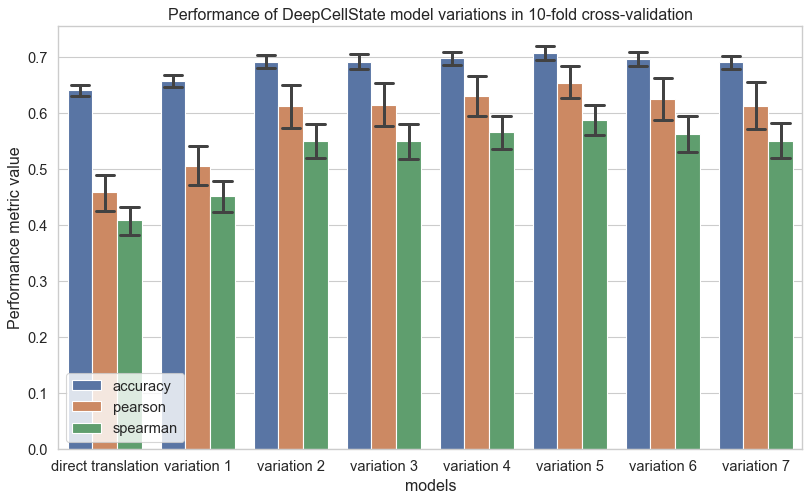

In [27]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_to_a375,
            order=['direct translation','variation 1',
                   'variation 2','variation 3',
                   'variation 4','variation 5',
                   'variation 6','variation 7'],hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of DeepCellState model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/deepcellstate/10fold_validation_deepcellstate_variations_landmarks_a375.png', bbox_inches='tight',dpi=600)

In [28]:
from scipy import stats

In [29]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7','direct translation']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-29-bf378d05191c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
<ipython-input-29-bf378d05191c>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values


In [30]:
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='spearman'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-30-2bb75a293747>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='spearman'].value.values
<ipython-input-30-2bb75a293747>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='spearman'].value.values


In [31]:
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='accuracy'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-31-748d6dd7cfa5>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='accuracy'].value.values
<ipython-input-31-748d6dd7cfa5>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='accuracy'].value.values


In [32]:
a375_translate = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
a375_translate = a375_translate[['metric','variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7','direct translation']]
a375_translate.to_csv('../results/deepcellstate_results/a375_translation_pvalues_table.csv')
a375_translate

,metric,variation 1,variation 2,variation 3,variation 4,variation 5,variation 6,variation 7,direct translation
variation 1,pearson,1.0,0.003611,0.003611,0.001008,0.000330,0.002202,0.003611,0.088973
variation 2,pearson,0.0,1.000000,0.677585,0.520523,0.212294,0.520523,1.000000,0.000440
variation 3,pearson,0.0,0.000000,1.000000,0.677585,0.241322,0.623176,0.850107,0.000330
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.427355,0.791337,0.520523,0.000183
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000,0.472676,0.185877,0.000183
variation 6,pearson,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.570750,0.000246
variation 7,pearson,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000440
direct translation,pearson,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.003611,0.003611,0.000769,0.000246,0.001315,0.003611,0.037635
variation 2,spearman,0.0,1.000000,1.000000,0.520523,0.185877,0.472676,0.969850,0.000183


### Same but for reconstruction

In [33]:
res_recon_a375 = results.loc[:,['recon_pear_a375','recon_spear_a375','recon_acc_a375','model']]
res_recon_a375.columns = ['pearson','spearman','accuracy','model']
res_recon_a375

,pearson,spearman,accuracy,model
0,0.755819,0.668349,0.742885,variation 5
1,0.740270,0.636114,0.729090,variation 5
2,0.761579,0.671027,0.745970,variation 5
3,0.738939,0.633424,0.730913,variation 5
4,0.752438,0.654669,0.739528,variation 5
...,...,...,...,...
5,0.837045,0.785697,0.803920,variation 3
6,0.824141,0.772629,0.795271,variation 3
7,0.814996,0.773012,0.798313,variation 3
8,0.824502,0.780120,0.800596,variation 3


In [34]:
res_recon_a375 = pd.melt(res_recon_a375,id_vars=['model'])
res_recon_a375.columns = ['model','metric','value']
res_recon_a375

,model,metric,value
0,variation 5,pearson,0.755819
1,variation 5,pearson,0.740270
2,variation 5,pearson,0.761579
3,variation 5,pearson,0.738939
4,variation 5,pearson,0.752438
...,...,...,...
205,variation 3,accuracy,0.803920
206,variation 3,accuracy,0.795271
207,variation 3,accuracy,0.798313
208,variation 3,accuracy,0.800596


[Text(0.5, 1.0, 'Performance of DeepCellState model variations in 10-fold cross-validation'),
 Text(0.5, 0, 'models'),
 Text(0, 0.5, 'Performance metric value')]

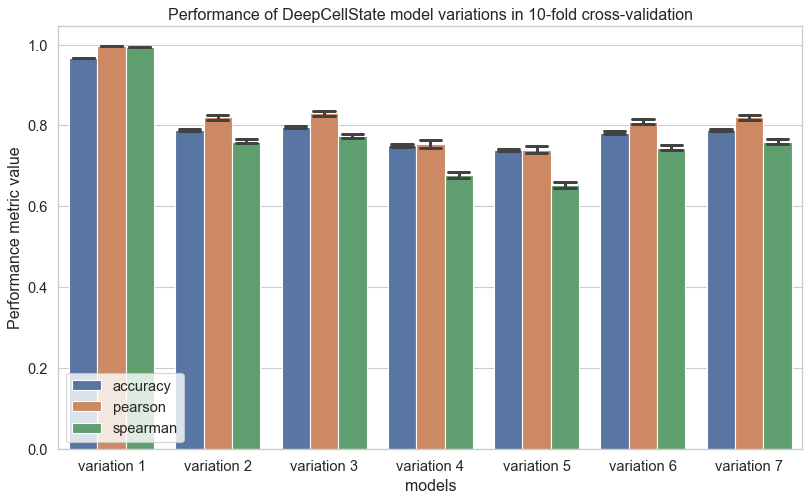

In [35]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_recon_a375,
            order=['variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7'],
            hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of DeepCellState model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/deepcellstate/10fold_validation_reconstruction_deepcellstate_variations_landmarks_a375.png', bbox_inches='tight',dpi=600)

In [36]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-36-3531178d5da8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
<ipython-input-36-3531178d5da8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values


In [37]:
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='spearman'].value.values
        x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-37-db2d8645d6f5>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='spearman'].value.values
<ipython-input-37-db2d8645d6f5>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='spearman'].value.values


In [38]:
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='accuracy'].value.values
        x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-38-7bf8ce6c3d50>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='accuracy'].value.values
<ipython-input-38-7bf8ce6c3d50>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='accuracy'].value.values


In [39]:
a375_reconstruction = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
a375_reconstruction = a375_reconstruction[['metric','variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7']]
a375_reconstruction.to_csv('../results/deepcellstate_results/a375_allgenes_reconstruction_pvalues_table.csv')
a375_reconstruction

,metric,variation 1,variation 2,variation 3,variation 4,variation 5,variation 6,variation 7
variation 1,pearson,1.0,0.003611,0.003611,0.001008,0.000330,0.002202,0.003611
variation 2,pearson,0.0,1.000000,0.677585,0.520523,0.212294,0.520523,1.000000
variation 3,pearson,0.0,0.000000,1.000000,0.677585,0.241322,0.623176,0.850107
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.427355,0.791337,0.520523
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000,0.472676,0.185877
variation 6,pearson,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.570750
variation 7,pearson,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
variation 2,spearman,0.0,1.000000,0.003611,0.000183,0.000183,0.002202,0.909722
variation 3,spearman,0.0,0.000000,1.000000,0.000183,0.000183,0.000183,0.002827


## HT29 trasnlation

In [40]:
res_to_ht29 = results.loc[:,['model_pearsonHT29','model_spearHT29','model_accHT29','model']]
res_to_ht29.columns = ['pearson','spearman','accuracy','model']
res_baseline = baseline.loc[:,['Direct_pearson','Direct_spearman','DirectAcc_ht29']]
res_baseline['model'] = 'direct translation'
res_baseline.columns = ['pearson','spearman','accuracy','model']
res_to_ht29 = pd.concat([res_to_ht29,res_baseline],axis=0)
res_to_ht29

,pearson,spearman,accuracy,model
0,0.730147,0.652637,0.727326,variation 5
1,0.690422,0.595961,0.713522,variation 5
2,0.777014,0.683527,0.741334,variation 5
3,0.706364,0.568136,0.699387,variation 5
4,0.758954,0.636765,0.725000,variation 5
...,...,...,...,...
5,0.456026,0.433163,0.654525,direct translation
6,0.391251,0.353916,0.618405,direct translation
7,0.455651,0.433182,0.652428,direct translation
8,0.373686,0.337688,0.610148,direct translation


In [41]:
res_to_ht29 = pd.melt(res_to_ht29,id_vars=['model'])
res_to_ht29.columns = ['model','metric','value']
res_to_ht29

,model,metric,value
0,variation 5,pearson,0.730147
1,variation 5,pearson,0.690422
2,variation 5,pearson,0.777014
3,variation 5,pearson,0.706364
4,variation 5,pearson,0.758954
...,...,...,...
235,direct translation,accuracy,0.654525
236,direct translation,accuracy,0.618405
237,direct translation,accuracy,0.652428
238,direct translation,accuracy,0.610148


[Text(0.5, 1.0, 'Performance of DeepCellState model variations in 10-fold cross-validation'),
 Text(0.5, 0, 'models'),
 Text(0, 0.5, 'Performance metric value')]

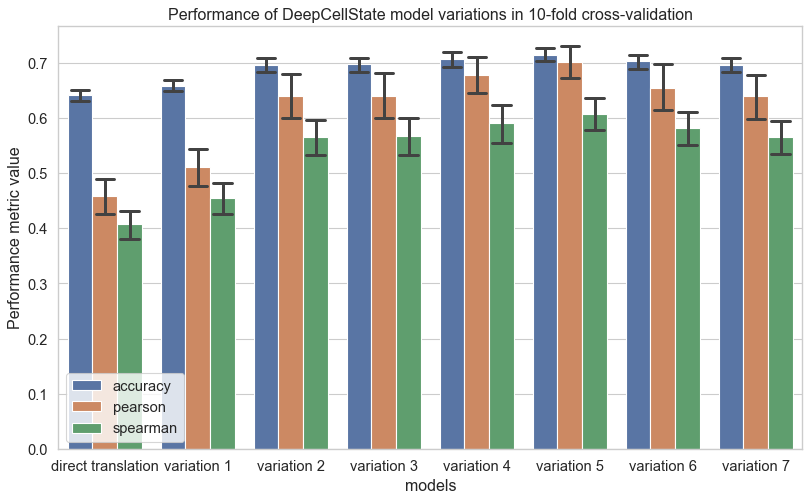

In [42]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_to_ht29,
            order=['direct translation','variation 1',
                   'variation 2','variation 3',
                   'variation 4','variation 5',
                   'variation 6','variation 7'],hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of DeepCellState model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/deepcellstate/10fold_validation_deepcellstate_variations_landmarks_ht29.png', bbox_inches='tight',dpi=600)

In [43]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7','direct translation']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='pearson'].value.values
        x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-43-7e3689c986f2>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='pearson'].value.values
<ipython-input-43-7e3689c986f2>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='pearson'].value.values


In [44]:
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='spearman'].value.values
        x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-44-2b2bd44095e3>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='spearman'].value.values
<ipython-input-44-2b2bd44095e3>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='spearman'].value.values


In [45]:
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='accuracy'].value.values
        x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-45-c5c1bf237c12>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='accuracy'].value.values
<ipython-input-45-c5c1bf237c12>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='accuracy'].value.values


In [46]:
ht29_translate = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
ht29_translate = ht29_translate[['metric','variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7','direct translation']]
ht29_translate.to_csv('../results/deepcellstate_results/ht29_translation_pvalues_table.csv')
ht29_translate

,metric,variation 1,variation 2,variation 3,variation 4,variation 5,variation 6,variation 7,direct translation
variation 1,pearson,1.0,0.002202,0.002202,0.000183,0.000183,0.001008,0.001706,0.075662
variation 2,pearson,0.0,1.000000,1.000000,0.273036,0.045155,0.384673,0.969850,0.000183
variation 3,pearson,0.0,0.000000,1.000000,0.273036,0.045155,0.384673,0.969850,0.000183
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.384673,0.427355,0.241322,0.000183
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000,0.212294,0.037635,0.000183
variation 6,pearson,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.384673,0.000183
variation 7,pearson,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000183
direct translation,pearson,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.001008,0.001315,0.000246,0.000183,0.000330,0.001008,0.031209
variation 2,spearman,0.0,1.000000,0.909722,0.384673,0.185877,0.472676,0.969850,0.000183


### Same but for reconstruction

In [47]:
res_recon_ht29 = results.loc[:,['recon_pear_ht29','recon_spear_ht29','recon_acc_ht29','model']]
res_recon_ht29.columns = ['pearson','spearman','accuracy','model']
res_recon_ht29

,pearson,spearman,accuracy,model
0,0.777120,0.703462,0.759630,variation 5
1,0.774754,0.689518,0.752361,variation 5
2,0.753705,0.680977,0.752491,variation 5
3,0.757096,0.662595,0.744088,variation 5
4,0.785107,0.713340,0.769818,variation 5
...,...,...,...,...
5,0.854575,0.805153,0.817447,variation 3
6,0.849256,0.798568,0.814408,variation 3
7,0.860740,0.817351,0.825916,variation 3
8,0.837538,0.795348,0.810476,variation 3


In [48]:
res_recon_ht29 = pd.melt(res_recon_ht29,id_vars=['model'])
res_recon_ht29.columns = ['model','metric','value']
res_recon_ht29

,model,metric,value
0,variation 5,pearson,0.777120
1,variation 5,pearson,0.774754
2,variation 5,pearson,0.753705
3,variation 5,pearson,0.757096
4,variation 5,pearson,0.785107
...,...,...,...
205,variation 3,accuracy,0.817447
206,variation 3,accuracy,0.814408
207,variation 3,accuracy,0.825916
208,variation 3,accuracy,0.810476


[Text(0.5, 1.0, 'Performance of DeepCellState model variations in 10-fold cross-validation'),
 Text(0.5, 0, 'models'),
 Text(0, 0.5, 'Performance metric value')]

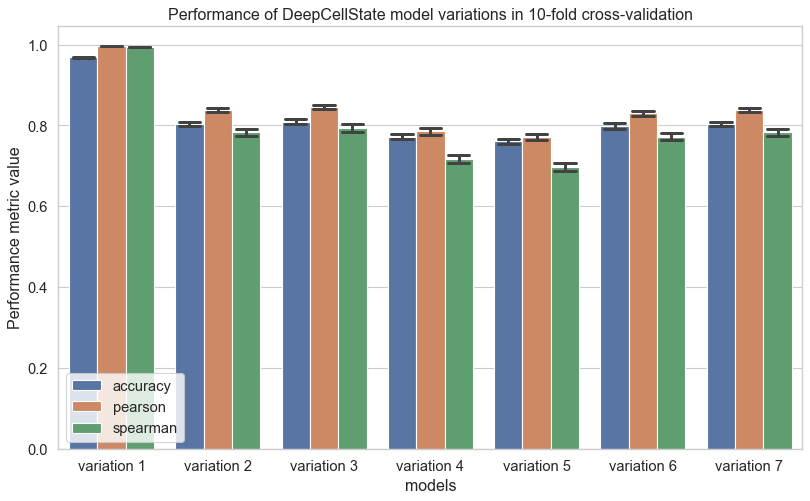

In [50]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_recon_ht29,
            order=['variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7'],
            hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of DeepCellState model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/deepcellstate/10fold_validation_reconstruction_deepcellstate_variations_landmarks_ht29.png', bbox_inches='tight',dpi=600)

In [51]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='pearson'].value.values
        x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-51-0d8b4db8ef54>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='pearson'].value.values
<ipython-input-51-0d8b4db8ef54>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='pearson'].value.values


In [52]:
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='spearman'].value.values
        x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-52-d8298965d0b4>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='spearman'].value.values
<ipython-input-52-d8298965d0b4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='spearman'].value.values


In [53]:
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='accuracy'].value.values
        x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-53-12b8fd9ef33b>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='accuracy'].value.values
<ipython-input-53-12b8fd9ef33b>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='accuracy'].value.values


In [54]:
a375_reconstruction = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
a375_reconstruction = a375_reconstruction[['metric','variation 1','variation 2','variation 3','variation 4','variation 5','variation 6','variation 7']]
a375_reconstruction.to_csv('../results/deepcellstate_results/ht29_reconstruction_pvalues_table.csv')
a375_reconstruction

,metric,variation 1,variation 2,variation 3,variation 4,variation 5,variation 6,variation 7
variation 1,pearson,1.0,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
variation 2,pearson,0.0,1.000000,0.075662,0.000183,0.000183,0.088973,0.909722
variation 3,pearson,0.0,0.000000,1.000000,0.000183,0.000183,0.007285,0.104110
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.025748,0.000183,0.000183
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000,0.000183,0.000183
variation 6,pearson,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.075662
variation 7,pearson,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
variation 2,spearman,0.0,1.000000,0.104110,0.000183,0.000183,0.104110,1.000000
variation 3,spearman,0.0,0.000000,1.000000,0.000183,0.000183,0.009108,0.121225
